In [1]:
import os, time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import torch
import pickle
import matplotlib.pyplot as plt
import math

Before running, modify the last part of gene_thicket.py, to save the model and be able to load it again.

In [2]:
import sys

sys.path.append("/home/lorena/Documents/Lorena_Thesis/Causal_CNN/")

from libs.network_analysis import evaluation
from libs.run_gene_thicket import run_gene_thicket
from libs.causal_cnn import LaRed
from libs.gene_thicket import preparedata
from libs.network_analysis import plot_graph, scores, plot_scores, plot_cartography, evaluation

In [3]:
temp_path = './beeline_data/synthetic/dyn-LI/dyn-LI-2000-2'

gem = pd.read_csv(temp_path + '/ExpressionData.csv', index_col = 0) #read gem
pseudotime = pd.read_csv(temp_path + '/PseudoTime.csv', index_col = 0) #is distributed in columns, we need to make it one
pseudotime_all = pd.DataFrame({'pseudotime': pseudotime.fillna(0).sum(axis=1)}) #make one pseudotime
gem = gem.T #transpose
gem['pseudotime'] = pseudotime_all.values #add pseudotime to gem
        
data = gem.sort_values(by='pseudotime').drop('pseudotime', axis=1) #sort gem according to pseudotime
refs = pd.read_csv(temp_path + '/refNetwork.csv') #ground truth

In [4]:
links, _, losses =  run_gene_thicket(data, cuda=False, levels=0, patience=20)


 Analysis started for target:  g1
Epoch:  1 [0%] 	Loss: 1.096028
Early stopping

 Analysis started for target:  g2
Epoch:  1 [0%] 	Loss: 3.492541
Early stopping

 Analysis started for target:  g3
Epoch:  1 [0%] 	Loss: 3.657160
Early stopping

 Analysis started for target:  g4
Epoch:  1 [0%] 	Loss: 3.734912
Early stopping

 Analysis started for target:  g5
Epoch:  1 [0%] 	Loss: 3.676186
Early stopping

 Analysis started for target:  g6
Epoch:  1 [0%] 	Loss: 3.614997
Early stopping

 Analysis started for target:  g7
Epoch:  1 [0%] 	Loss: 3.344028
Early stopping


In [5]:
links

,TF,importance,target
0,g5,2.158614,g4
1,g6,2.020515,g5
2,g7,2.073144,g6
3,g5,2.020751,g6
4,g6,2.360955,g7


In [6]:
losses

{0: 0.5773490071296692,
 1: 0.2280767858028412,
 2: 0.3217150568962097,
 3: 0.29882603883743286,
 4: 0.2824256718158722,
 5: 0.262279748916626,
 6: 0.30938756465911865}

In [7]:
data

,g1,g2,g3,g4,g5,g6,g7
E1932_1,1.189249,0.171228,0.010000,0.011800,0.010000,0.002922,0.010000
E4785_1,0.869420,0.180097,0.010000,0.018782,0.003778,0.016265,0.011124
E1782_1,1.277380,0.177073,0.017751,0.008391,0.010000,0.005647,0.013169
E2772_1,0.997063,0.175528,0.008107,0.022790,0.011077,0.003006,0.010000
E4794_1,0.985298,0.176605,0.010000,0.010000,0.023994,0.022314,0.010000
...,...,...,...,...,...,...,...
E3889_498,0.616146,1.703573,2.360295,2.629917,1.732639,2.320460,1.787778
E93_498,0.001386,0.006672,2.223822,1.936650,1.891802,1.883921,1.866513
E1274_499,0.032757,0.493135,2.217024,1.491851,2.216725,1.576485,2.239619
E1566_499,0.009861,0.344725,1.364993,1.671629,1.805326,2.292493,1.810359


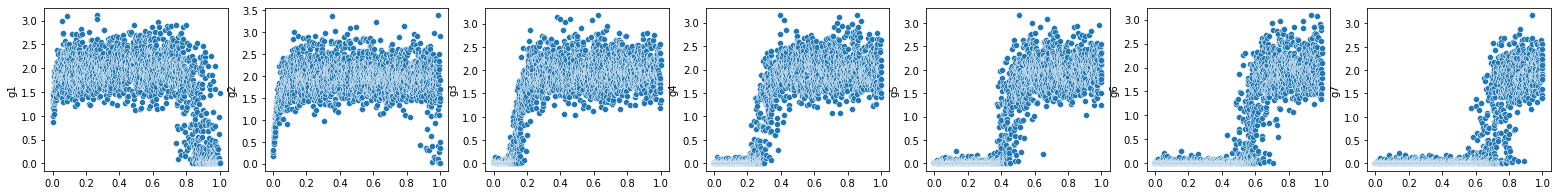

In [8]:
#time
time = pseudotime_all.sort_values(by='pseudotime').values.flatten()

fig, axs = plt.subplots(ncols=7, figsize=(27,3))

for i,col in enumerate(data.columns):
    sns.scatterplot(x=time, y=data[col], ax=axs[i])

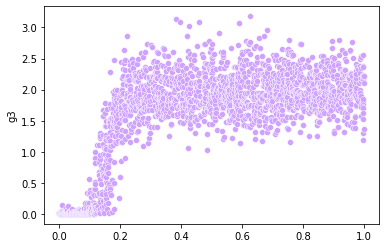

In [9]:
sns.scatterplot(x=time, y=data['g3'], color="xkcd:lilac")
plt.savefig('./Plots/causality_g3.png', dpi=150, transparent=True, bbox_inches='tight')

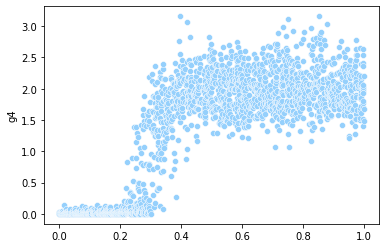

In [10]:
sns.scatterplot(x=time, y=data['g4'], color="xkcd:light blue")
plt.savefig('./Plots/causality_g4.png', dpi=150, transparent=True, bbox_inches='tight')

In [11]:
#general parameters
gem = data.copy()
epochs = 1000
kernel_size = 4
layers = 0
lr = 0.01
optimizername = 'Adam'
seed = 1111
dilation_c = 4
input_channels = gem.shape[1]-1

In [12]:
model = LaRed(input_channels, layers, kernel_size=kernel_size, cuda=False, dilation_c=dilation_c)

In [13]:
all_genes = list(data.columns)

In [14]:
sel_genes = ['g1', 'g2', 'g6', 'g7']

In [15]:
sns.set_style("whitegrid")

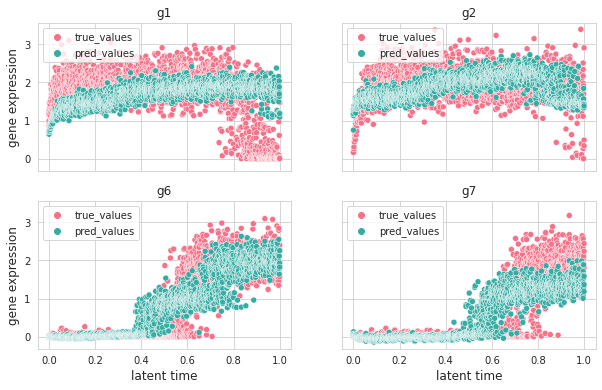

In [16]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(10, 6))

#plt.figure(ncols=2, figsize=(20,10))

for i, el in enumerate(sel_genes):
    
    #parameters
    target_name = el
    tfs_name = all_genes.copy()
    tfs_name.remove(target_name)
    
    #train_data
    X_train, _ = preparedata(target_name, tfs_name, gem)
    input_channels = X_train.size()[1]
    
    #load model
    model.load_state_dict(torch.load('./saved_models/' + target_name + '.pt'))
    
    #predicted values
    model.eval()
    pred_values = model(X_train)
    pred_values = pred_values.cpu()
    pred_values =pred_values.detach().numpy().flatten()
    
    #true values
    true_values = data[target_name].values
    
    #data frame to plot
    df = pd.DataFrame({'time':time, 'true_values':true_values, 'pred_values':pred_values})
    df_plot = pd.melt(df, id_vars=['time'], value_vars=['true_values', 'pred_values'])
    
    sns.scatterplot(data=df_plot, x="time", y="value", hue="variable", palette=sns.color_palette("husl", 2), ax = axs[math.floor(i/2),i%2])
    axs[math.floor(i/2),i%2].set_title(el)
    if (math.floor(i/2) == 0) | (math.floor(i/2) == 1):
        axs[math.floor(i/2),i%2].set_ylabel('gene expression', fontsize=12)
    if (math.floor(i/2) == 1):
        axs[math.floor(i/2),i%2].set_xlabel('latent time', fontsize=12)
        
    axs[math.floor(i/2),i%2].legend(loc='upper left')
    
    #axs[math.floor(i/2),i%2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 10})
    
plt.savefig("./Plots/prediction_example.png", dpi=150, transparent=True, bbox_inches='tight')

/home/lorena/anaconda3/envs/causal_cnn_env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


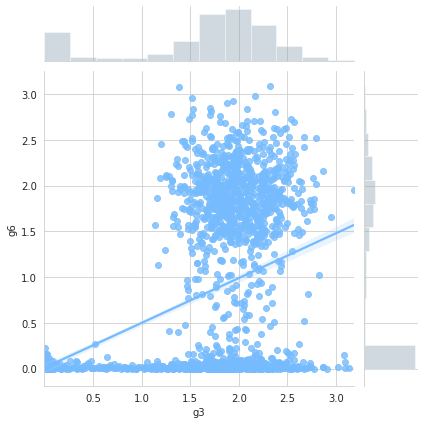

In [17]:
g = sns.JointGrid(x=data['g3'], y=data['g6'])
#g = sns.JointGrid(data=df, x='Height', y='Weight', xlim=(140, 190), ylim=(40, 100), height=5)
g = g.plot_joint(sns.regplot, color="xkcd:sky blue")
g = g.plot_marginals(sns.distplot, kde=False, bins=12, color="xkcd:bluey grey")
#g.ax_joint.text(145, 95, 'r = 0.45, p < .001', fontstyle='italic')